In [11]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [12]:
from transpile_benchy.interfaces.qiskit_interface import (
    # QiskitCircuitInterface,
    QuantumCircuitFactory,
)
from qiskit.circuit.library import TwoLocal

num_qubits = [8, 16, 24, 32, 40, 48]


def full(n):
    return TwoLocal(n, "ry", "cz", entanglement="full", reps=3)


def linear(n):
    return TwoLocal(n, "ry", "cz", entanglement="linear", reps=3)

In [13]:
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary.from_submodules(
    [
        QuantumCircuitFactory(full, num_qubits),
        # QuantumCircuitFactory(linear_two_local, num_qubits),
    ]
)

In [21]:
from transpile_benchy.passmanagers.qiskit_baseline import QiskitBaseline
from qiskit.transpiler import CouplingMap
from quantum_logical.coupling_util import CorralCoupling, TreeCoupling

heavy_hex = CouplingMap.from_heavy_hex(5)
square_lattice = CouplingMap.from_grid(7, 7)
corral = CorralCoupling(14)
tree = TreeCoupling(4, 4)

baseline_sq = QiskitBaseline(optimization_level=3, coupling_map=square_lattice)
baseline_hh = QiskitBaseline(optimization_level=3, coupling_map=heavy_hex)

# FIXME, we don't have a way of distinguishing between these transpilers w/o a name
baseline_sq.name = "square_lattice"
baseline_hh.name = "heavy_hex"

transpilers = [baseline_sq, baseline_hh]

In [15]:
from transpile_benchy.metrics.abc_metrics import MetricInterface
from qiskit.transpiler.basepasses import AnalysisPass
from monodromy.coverage import convert_gate_to_monodromy_coordinate
import numpy as np
from transpile_benchy.metrics.abc_metrics import DoNothing


class CombinedMetricsPass(AnalysisPass):
    """Combined pass for calculating CCR, Mean Qubit Hotspotness, and Temporal Burstiness."""

    def __init__(self):
        super().__init__()

    def run(self, dag):
        # Initialize counters and storage
        num_swap = 0
        num_computation = 0
        swap_counts = {q: 0 for q in dag.qubits}
        layer_swap_counts = []

        for layer_i, layer in enumerate(dag.layers()):
            layer_swap_counts.append(0)
            for gate_node in layer["graph"].two_qubit_ops():
                t_c = convert_gate_to_monodromy_coordinate(gate_node.op)
                if np.allclose(t_c, [0.25, 0.25, 0.25, -0.75]):
                    num_swap += 1
                    layer_swap_counts[layer_i] += 1
                    for q in gate_node.qargs:
                        swap_counts[q] += 1
                else:
                    num_computation += 1

        # Calculate metrics
        ccr = num_swap / num_computation if num_computation != 0 else 0
        mean_swap = np.mean(list(swap_counts.values()))
        variance_swap = np.var(list(swap_counts.values()))
        mean_qubit_hotspotness = variance_swap / mean_swap if mean_swap != 0 else 0
        layer_mean_swap = np.mean(layer_swap_counts)
        layer_variance_swap = np.var(layer_swap_counts)
        temporal_burstiness = (
            layer_variance_swap / layer_mean_swap if layer_mean_swap != 0 else 0
        )

        # Store metrics in the property set
        self.property_set["ccr"] = ccr
        self.property_set["mean_qubit_hotspotness"] = mean_qubit_hotspotness
        self.property_set["temporal_burstiness"] = temporal_burstiness


class CCR(MetricInterface):
    """CCR metric utilizing the CombinedMetricsPass for computation."""

    def __init__(self):
        super().__init__(name="ccr", pretty_name="CCR")

    def _construct_pass(self):
        return CombinedMetricsPass()


class MeanQubitHotspotness(MetricInterface):
    """Mean Qubit Hotspotness metric that extracts its value after CombinedMetricsPass has run."""

    def __init__(self):
        super().__init__(
            name="mean_qubit_hotspotness", pretty_name="Mean Qubit Hotspotness"
        )

    def _construct_pass(self):
        # This metric relies on the property set filled by the CombinedMetricsPass
        return DoNothing()


class TemporalBurstiness(MetricInterface):
    """Temporal Burstiness metric that extracts its value after CombinedMetricsPass has run."""

    def __init__(self):
        super().__init__(name="temporal_burstiness", pretty_name="Temporal Burstiness")

    def _construct_pass(self):
        # This metric relies on the property set filled by the CombinedMetricsPass
        return DoNothing()

In [16]:
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks

depth_metric = DepthMetric(consolidate=False)
total_metric = TotalMetric(consolidate=False)

ccr_metric = CCR()
mean_qubit_hotspotness_metric = MeanQubitHotspotness()
temporal_burstiness_metric = TemporalBurstiness()

metrics = [
    depth_metric,
    total_metric,
    ccr_metric,
    mean_qubit_hotspotness_metric,
    temporal_burstiness_metric,
]

requires = [Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)]

for transpiler in transpilers:
    transpiler._append_metric_dependencies(requires)

In [17]:
benchmark = Benchmark(
    transpilers=transpilers,
    metrics=metrics,
    circuit_library=lib,
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...
Circuits from library:   0%|          | 0/6 [00:00<?, ?it/s]INFO:transpile_benchy:Running benchmark for circuit full_n8


Loading full_n8 from QuantumCircuitFactory


Circuits from library:  17%|█▋        | 1/6 [00:01<00:05,  1.04s/it]INFO:transpile_benchy:Running benchmark for circuit full_n16


Loading full_n16 from QuantumCircuitFactory


Circuits from library:  33%|███▎      | 2/6 [00:04<00:10,  2.69s/it]INFO:transpile_benchy:Running benchmark for circuit full_n24


Loading full_n24 from QuantumCircuitFactory


Circuits from library:  50%|█████     | 3/6 [00:13<00:16,  5.40s/it]INFO:transpile_benchy:Running benchmark for circuit full_n32


Loading full_n32 from QuantumCircuitFactory


Circuits from library:  67%|██████▋   | 4/6 [00:28<00:18,  9.11s/it]INFO:transpile_benchy:Running benchmark for circuit full_n40


Loading full_n40 from QuantumCircuitFactory


Circuits from library:  83%|████████▎ | 5/6 [00:52<00:14, 14.39s/it]INFO:transpile_benchy:Running benchmark for circuit full_n48


Loading full_n48 from QuantumCircuitFactory


Circuits from library: 100%|██████████| 6/6 [01:27<00:00, 14.61s/it]


In [18]:
print(benchmark)


Transpiler: heavy_hex

  Metric: ccr
  Circuit: full_n16                                 Mean result: 0.936                          Trials: [0.8361111111111111, 0.9944444444444445, 0.9777777777777777]
  Circuit: full_n24                                 Mean result: 0.979                          Trials: [0.8405797101449275, 0.9963768115942029, 1.1002415458937198]
  Circuit: full_n32                                 Mean result: 0.980                          Trials: [1.073252688172043, 0.9690860215053764, 0.896505376344086]
  Circuit: full_n40                                 Mean result: 1.004                          Trials: [0.9512820512820512, 1.0452991452991454, 1.014957264957265]
  Circuit: full_n48                                 Mean result: 0.949                          Trials: [1.0212765957446808, 0.8486997635933806, 0.9757683215130024]
  Circuit: full_n8                                  Mean result: 0.766                          Trials: [0.7976190476190477, 0.7738095238095

In [19]:
benchmark.summary_statistics(baseline_sq, baseline_hh)

{'monodromy_depth': {'average_change': 37.31436585935496,
  'aggregrate_change': 44.52806841349805,
  'best_circuit': 'full_n8',
  'worst_circuit': 'full_n48'},
 'monodromy_total': {'average_change': 51.51994192253082,
  'aggregrate_change': 52.94990531515912,
  'best_circuit': 'full_n8',
  'worst_circuit': 'full_n24'},
 'ccr': {'average_change': 91.15239353416649,
  'aggregrate_change': 91.4624602327939,
  'best_circuit': 'full_n8',
  'worst_circuit': 'full_n40'},
 'mean_qubit_hotspotness': {'average_change': 215.34636910218754,
  'aggregrate_change': 170.78411092465038,
  'best_circuit': 'full_n8',
  'worst_circuit': 'full_n48'},
 'temporal_burstiness': {'average_change': 7.532697465395088,
  'aggregrate_change': 7.689875885029425,
  'best_circuit': 'full_n8',
  'worst_circuit': 'full_n48'},
 'total_runtime': {'average_change': 16.707900250096568,
  'aggregrate_change': 21.44422513295094,
  'best_circuit': 'full_n8',
  'worst_circuit': 'full_n24'}}

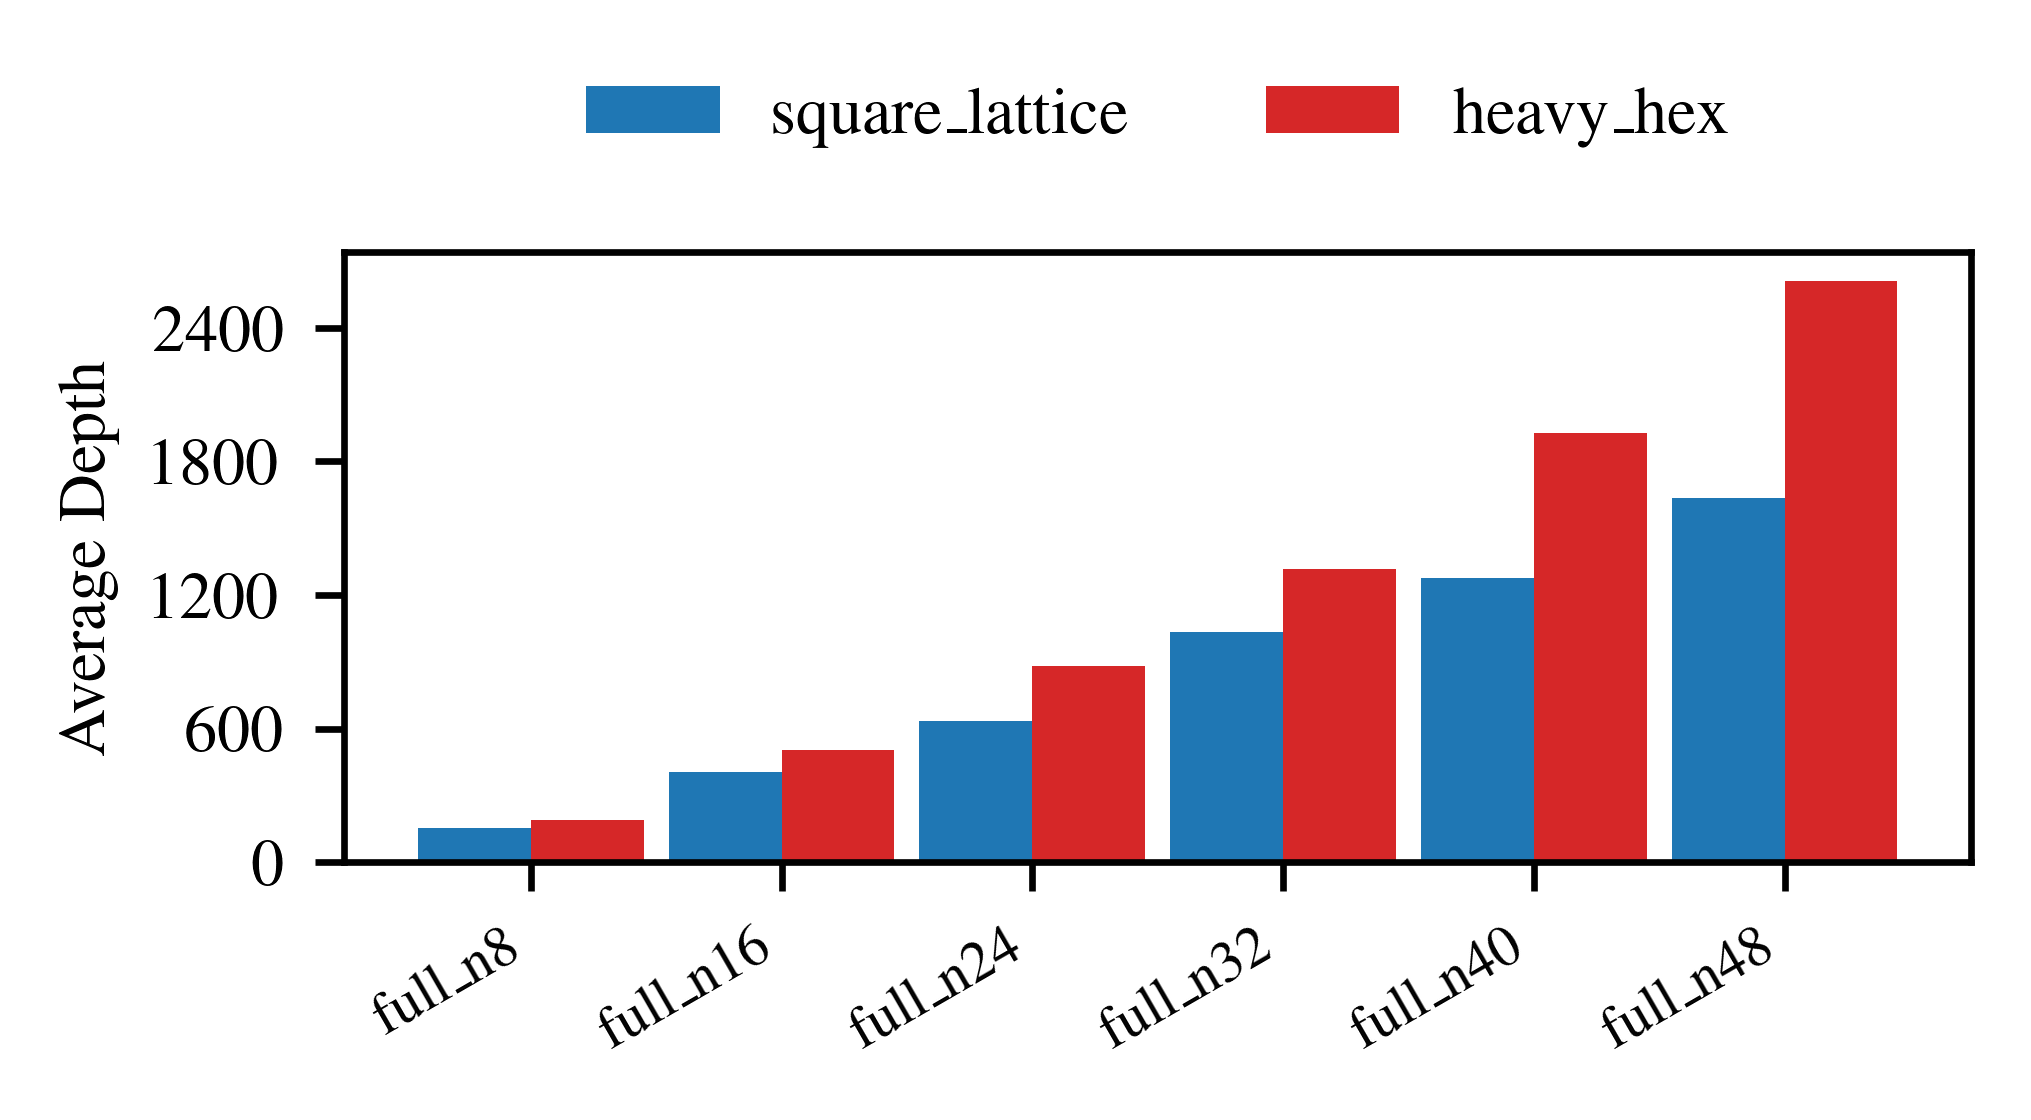

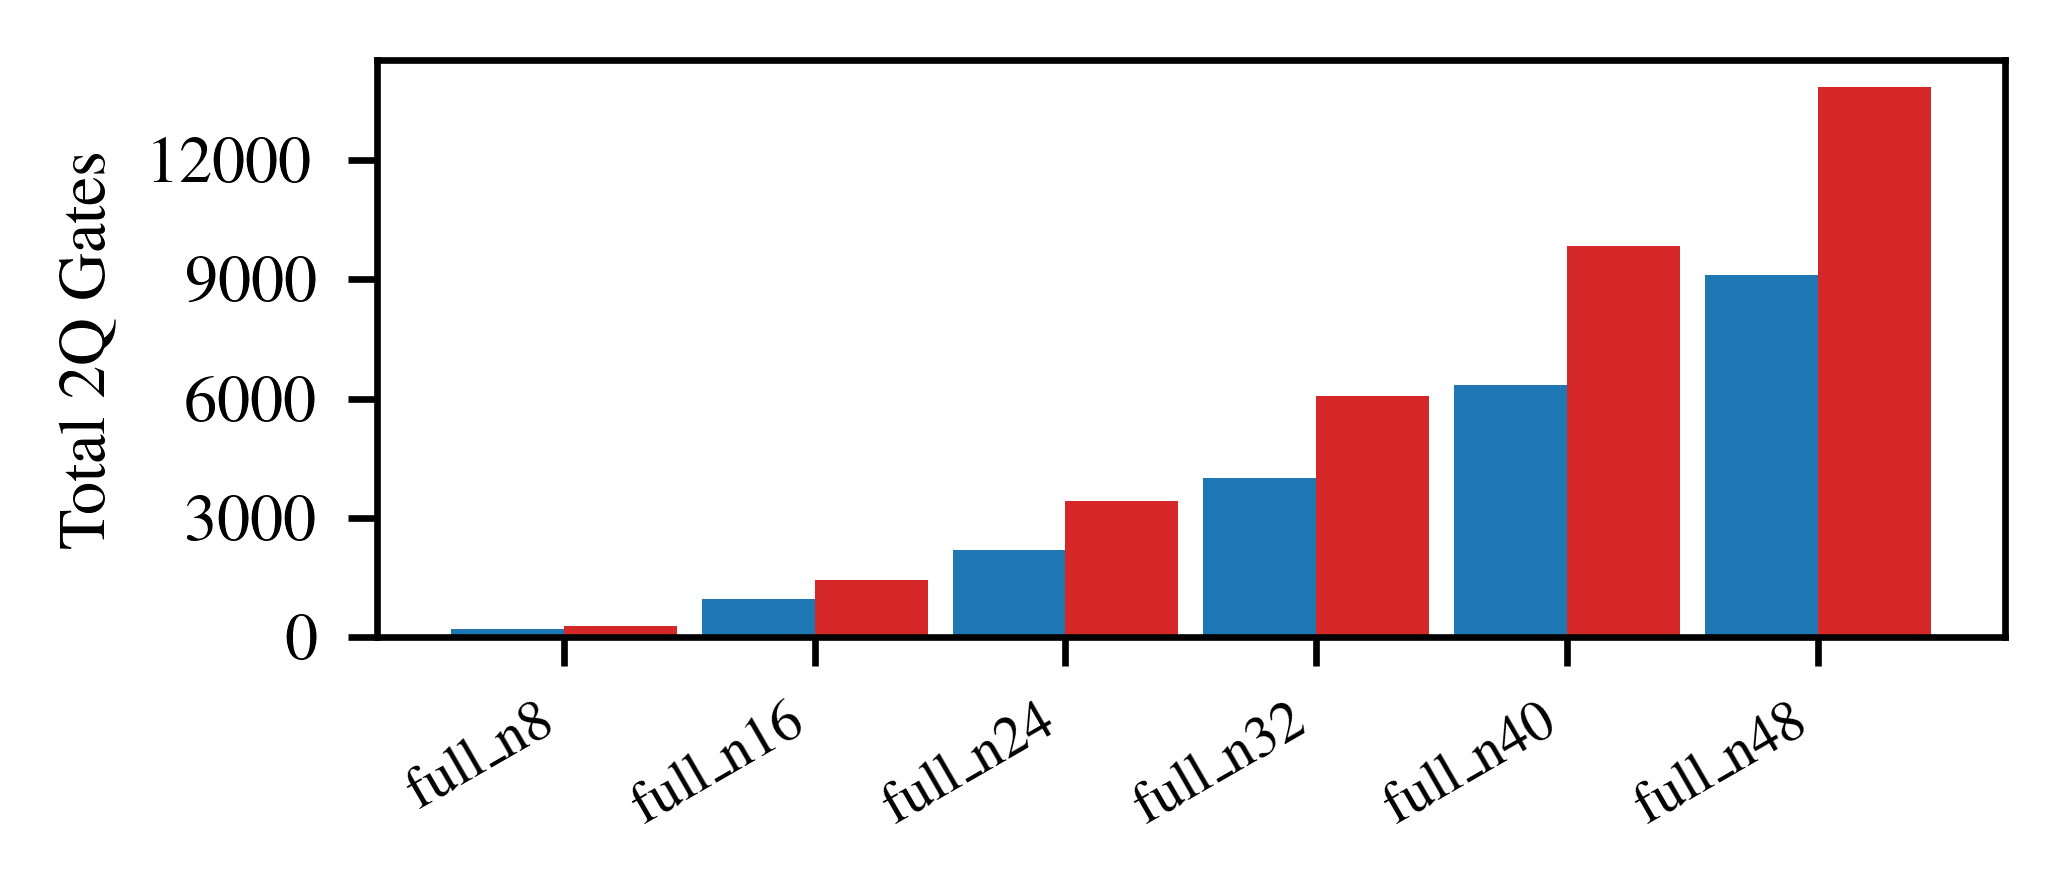

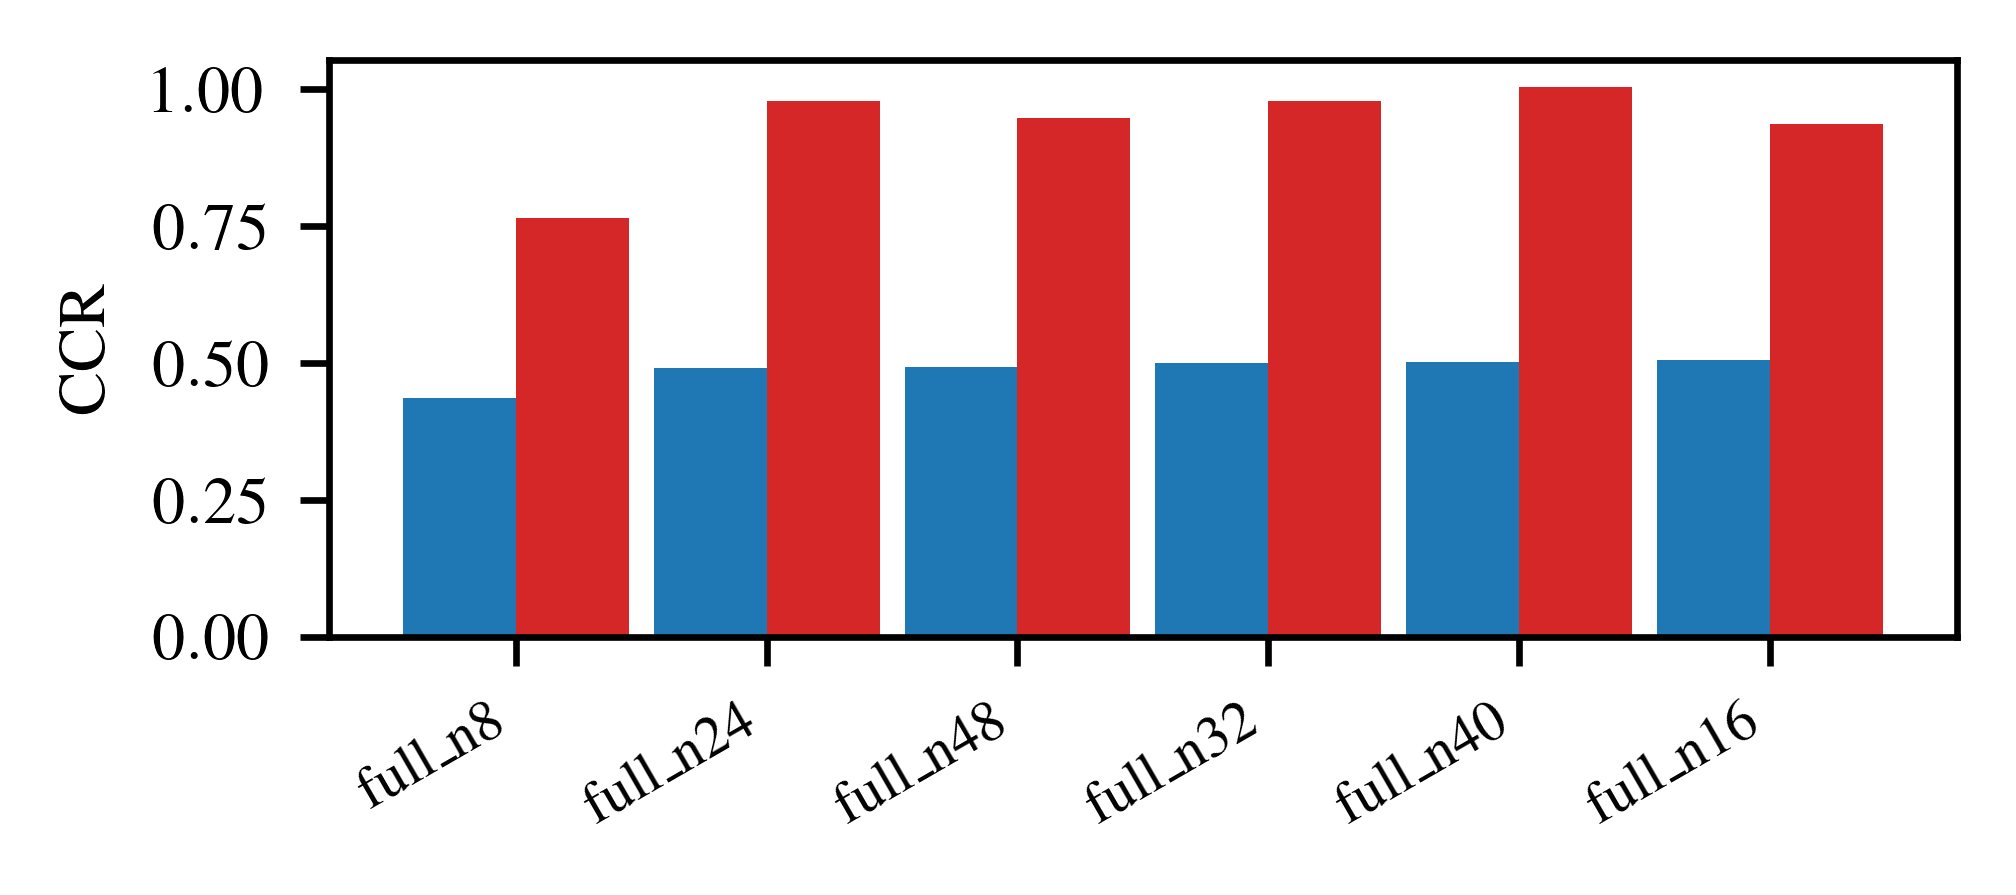

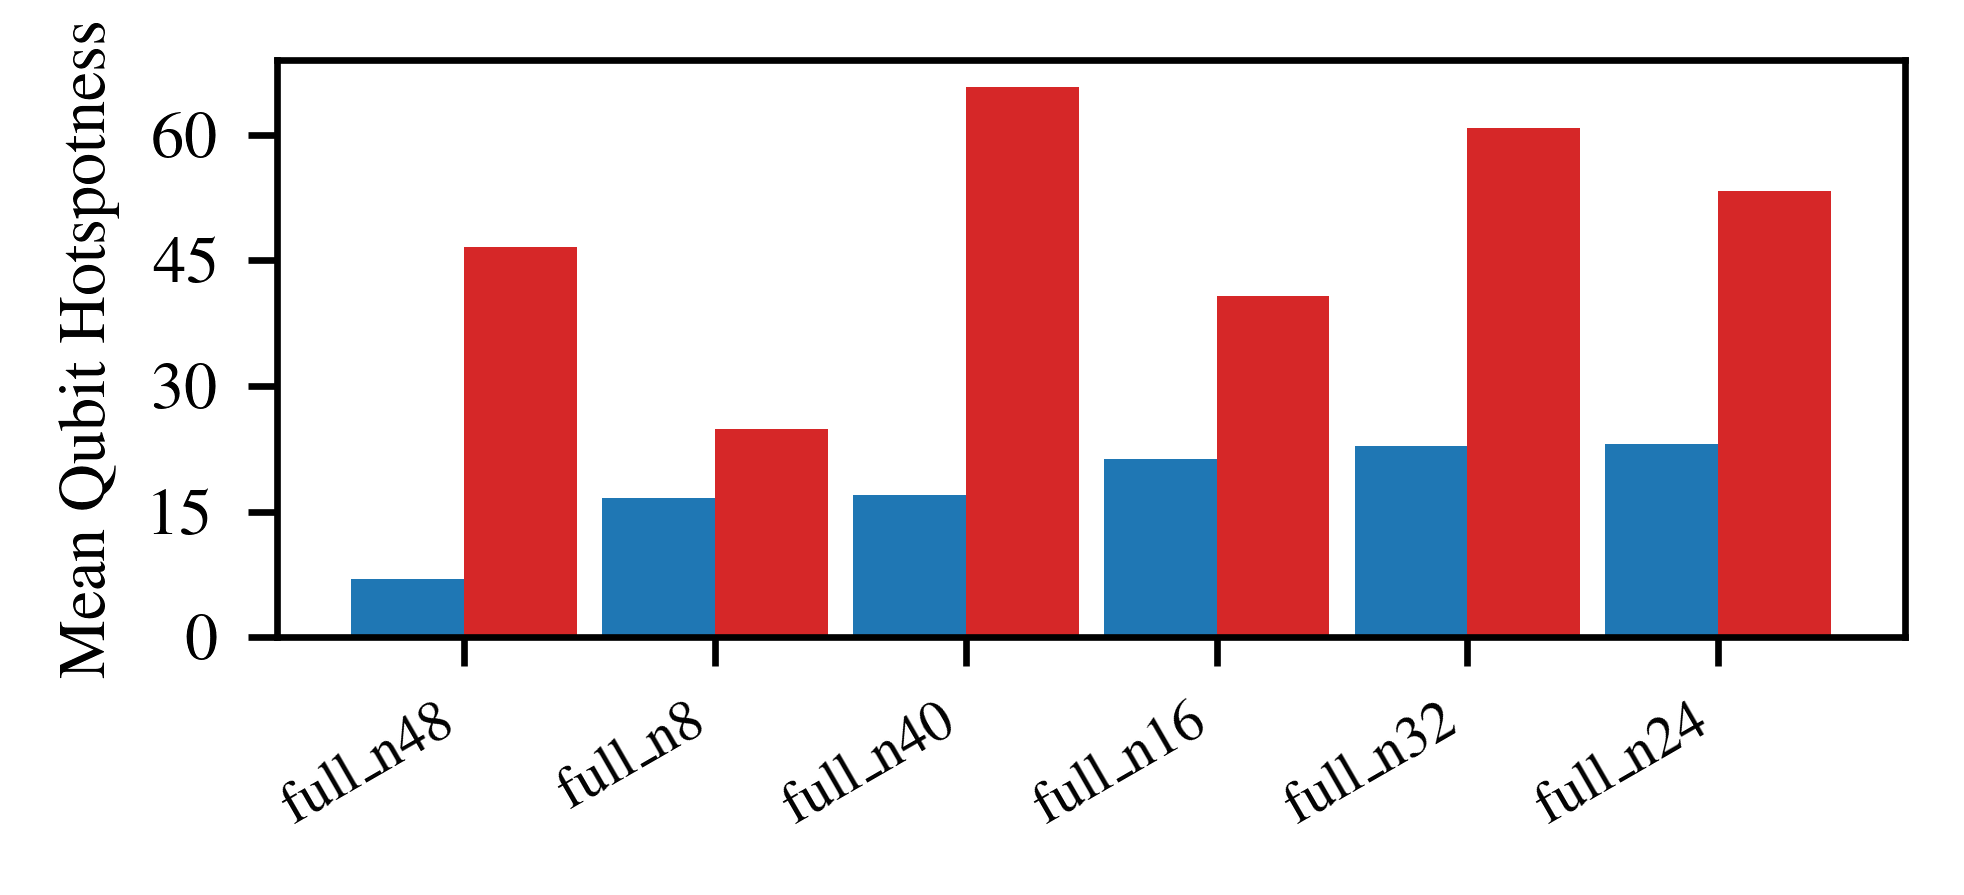

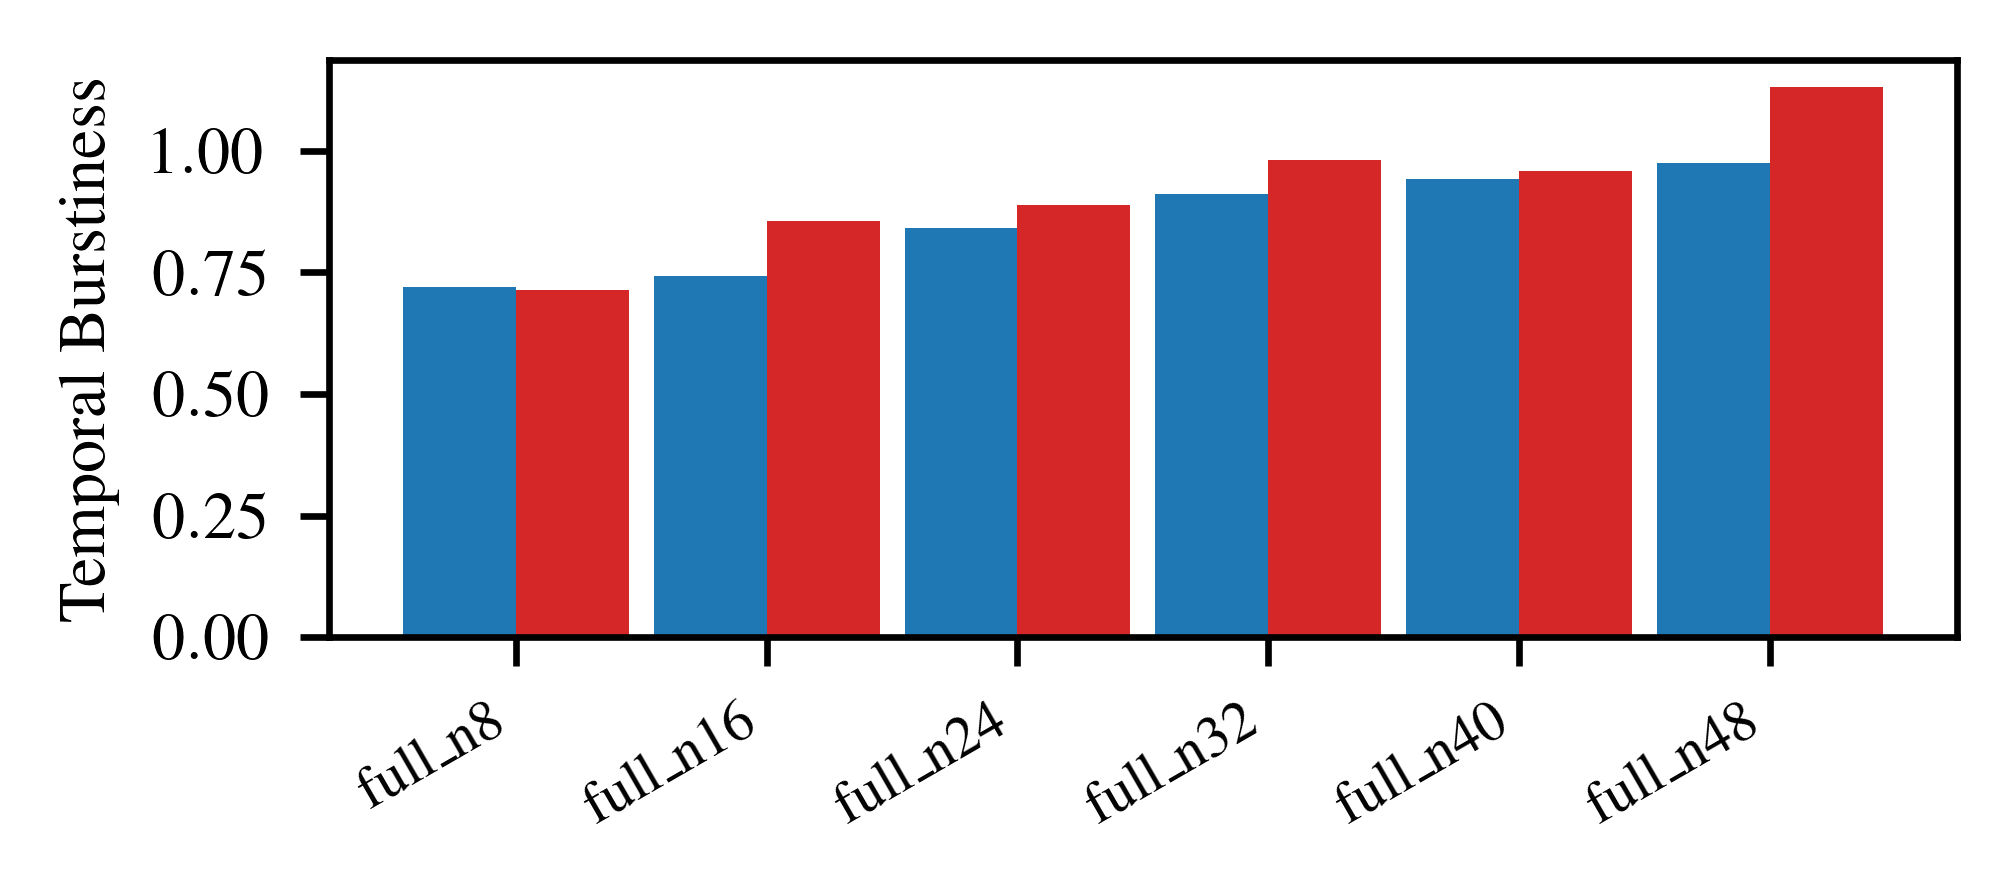

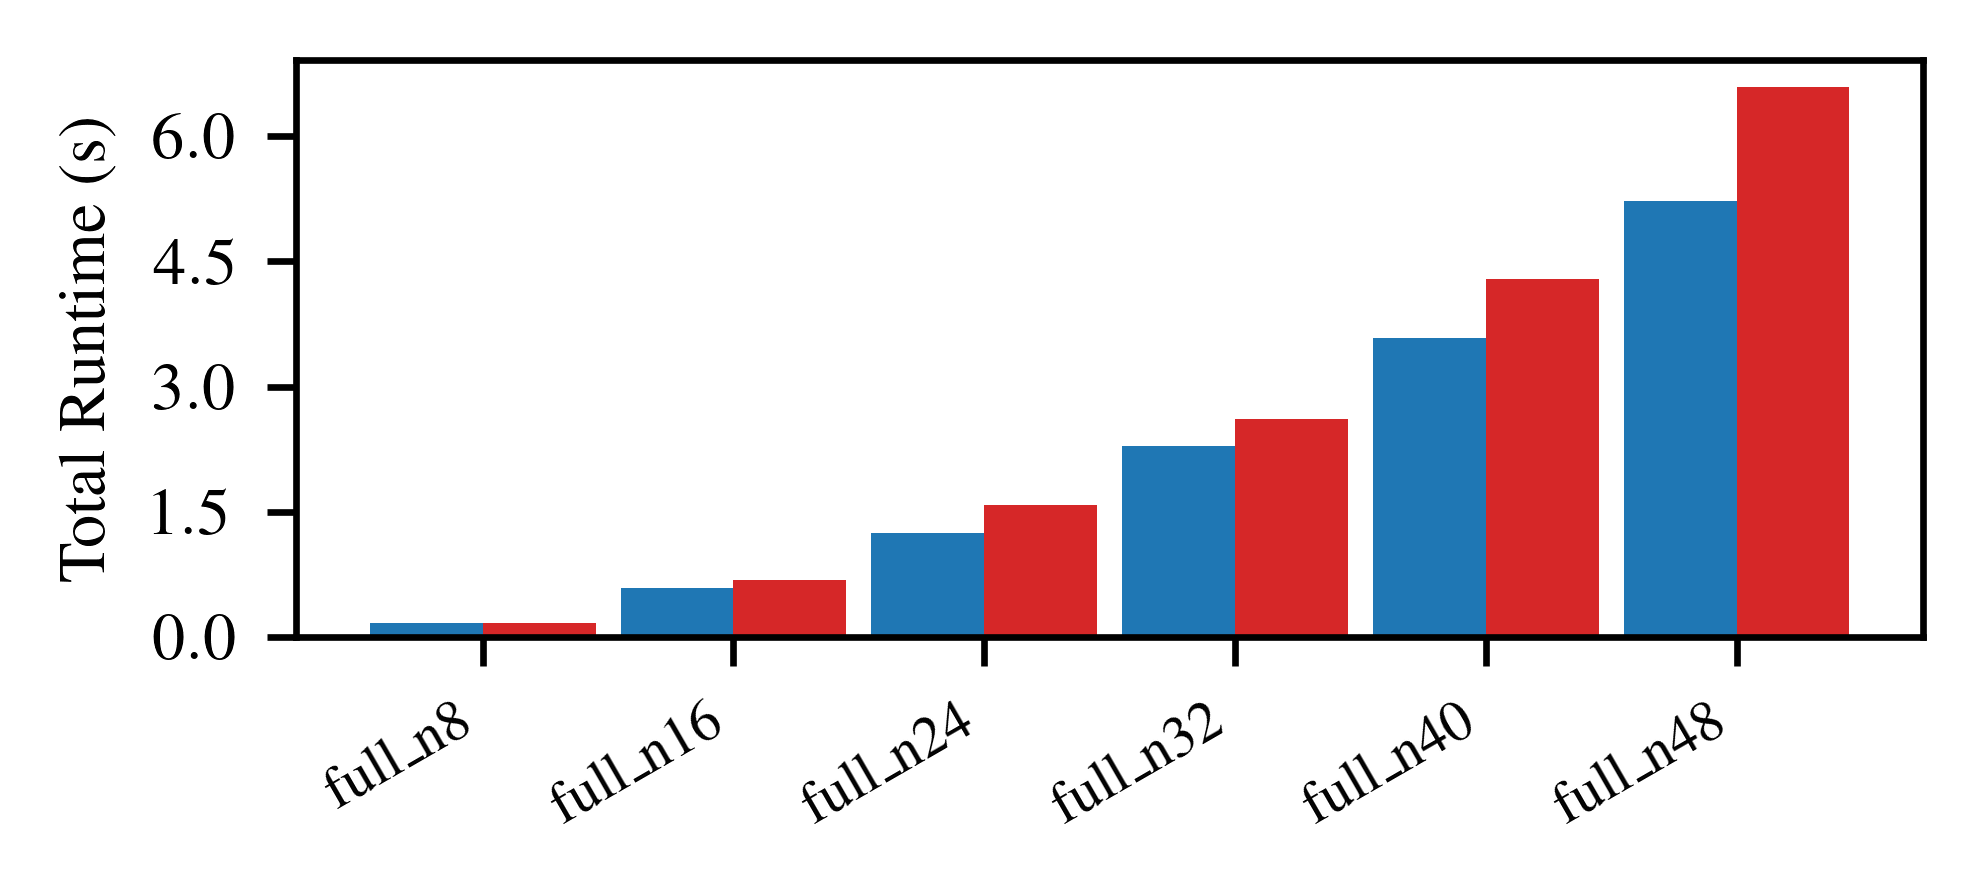

In [20]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark, save=0, legend_show=1, filename="grid", color_override=[0, 3])